# Kaggle Tabular Playground Series - Sep 2021

The aim of this project was to take part in and complete the Kaggle "Tabular Playground Series - Sep 2021" Prediction Competition. The competition consisted of predicting the probability of a customer making a claim on an insurance policy. The data used in this challenge came from a synthetic dataset. I chose this as my capstone project since it allowed me to put my knowledge and skills into practice but also explore new topics and learn new modelling techniques. 

The best solution I was able to achieve consisted of a voting classifier model containing the three highest-scoring available models I was able to train on my dataset. This solution was able to achieve good predictive performance both in-sample and out-of-sample, with AUC scores in excess of 83% when using the entire dataset to predict labels for the validation dataset. Other metrics scored highly as well, indicating the good performance of the chosen model. 

The project was concluded with the submission of the test predictions to the relevant competition submission page to finally  be scored. My best predictions allowed me to score in the top 37% of participants.

## Importing packages and functions

In [1]:
%%capture 
# command above avoids printing long console output

# installing the pycaret module and its sub-modules (only run in GPU mode)
!pip install pycaret[full]

In [2]:
## The "magic four"
import pandas as pd
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 

# Scaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# garbage collection (clear up some RAM and optimise available memory)
import gc

# imputer (fill in null values)
from sklearn.impute import SimpleImputer

# pycaret (only run in GPU mode)
from pycaret.classification import *

# cuDF
import cudf

%matplotlib inline

In [3]:
# this removes the many warnings that some functions and commands produce
# it helps significantly declutter the workbook
import warnings
warnings.filterwarnings('ignore')

# Importing data

In [4]:
# importing data and setting index column
# using cuDF to dramatically speed up data import
train = cudf.read_csv('../input/tabular-playground-series-sep-2021/train.csv', index_col='id')
test = cudf.read_csv('../input/tabular-playground-series-sep-2021/test.csv', index_col='id')

# Exploratory Data Analysis

In [5]:
train.head()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60,f61,f62,f63,f64,f65,f66,f67,f68,f69,f70,f71,f72,f73,f74,f75,f76,f77,f78,f79,f80,f81,f82,f83,f84,f85,f86,f87,f88,f89,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99,f100,f101,f102,f103,f104,f105,f106,f107,f108,f109,f110,f111,f112,f113,f114,f115,f116,f117,f118,claim
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.10859,0.004314,-37.566,0.017364,0.28915,-10.25100,135.12,168900.0,3.992400e+14,86.489,0.59881,1.423200e+09,0.27240,9.455600,-0.050305,1938.300,8.6331,4.0607,26.867,-1.18,10961.00,1.5397,135.3200,-1.49650,440.080,2.590100e+12,2.194200e+09,2968800.0,0.001431,13.3270,0.75050,18509.0,146820.0,-0.000276,1.090600e+16,1705.400,414.29,3.5392,1888.0,0.968930,18.3880,-0.001583,7.7059,5.9325,0.025693,4.5604,0.61122,10.7950,0.341930,0.235010,<NA>,5237.70,1.29610,163.66,0.403780,0.188600,-0.001446,-0.35416,6.6432,0.30534,0.514020,1.907300e+09,29.861,0.965010,1797.2,72.178,108.62,1.9799,1.2907,0.99519,1.3228,827.340,7.779900e+14,4.129900e+10,0.006994,6.9835,43956.0,1978.2,5.5084,-0.001081,6.1244,1.231800e+11,275.9200,5308500.0,1704.000,5.022400e+10,53.3980,-2.2012,6871.0,3.8862,-0.00558,5252.100,166.690,1.60740,0.66534,7768.900,0.99662,1.125700e+11,2.2432,0.934160,0.65056,94569.0,21.471,8214.100,0.288010,0.097826,0.001071,1.412400e+09,0.11093,-12.2280,1.7482,1.90960,-7.11570,4378.80,1.2096,8.613400e+14,140.1,1.01770,1
1,0.10090,0.299610,11822.000,0.276500,0.45970,-0.83733,1721.90,119810.0,3.874100e+15,9953.600,1.20930,3.334100e+09,0.28631,-0.012858,-0.019912,10.284,6.1872,1.0419,4.6404,31.877,123620.00,1.3951,125.8100,1.19890,136.450,9.098100e+09,4.004100e+10,1564000.0,0.000204,3.1074,1.50330,238000.0,21440.0,-0.001345,3.079400e+16,229.100,844.82,1.4680,4726.5,0.915380,-1.5321,0.982600,7.1112,2.0797,0.042321,4.2523,0.41871,5.4499,0.012737,0.386470,7.3082,283.21,-0.92552,140.80,0.247390,-0.001656,-0.000975,-0.22629,2.4246,0.77147,0.011613,1.803700e+09,64.604,0.262650,4455.0,78.339,745.51,2.9069,1.4826,1.00510,1.4974,84.446,3.505600e+15,2.242300e+09,0.896300,4.6749,17713.0,9003.1,-4.3546,0.254100,6.9191,1.832400e+11,9.6510,32800.0,1480.600,2.300600e+10,44.0510,205.6900,4295.3,13.388,0.46843,754.610,83.233,1.18900,29.55000,7343.700,0.99815,4.877700e+13,1.2708,-0.000969,5.29520,6779.0,227.720,34.342,0.340300,0.143370,0.049276,1.903200e+09,0.97673,-56.7580,4.1684,0.34808,4.14200,913.23,1.2464,7.575100e+15,1861.0,0.28359,0
2,0.17803,-0.006980,907.270,0.272140,0.45948,0.17327,2298.00,360650.0,1.224500e+13,15827.000,0.38164,1.230300e+09,0.25807,2.455600,<NA>,26.873,7.5463,1.9967,1.9526,817.76,-2948.70,2.0054,1.6826,1.19680,74.624,-3.273900e+10,5.718900e+10,11058.0,-0.003097,8.0241,1.13180,27940.0,862460.0,-0.002207,5.849100e+13,-897.840,<NA>,1.3561,3063.4,0.086232,16.1060,0.001481,11.4760,5.343,0.012162,4.1018,-0.88270,8.1228,-0.676690,0.337700,-1.0732,4097.00,13.45800,159.24,0.322300,0.560090,0.000455,-0.16083,3.5753,0.60970,0.028301,5.271300e+08,14.454,0.115490,14605.0,36.992,-9.6391,64.2670,<NA>,0.99278,2.5891,430.400,-4.453500e+13,5.144900e+12,0.099591,6.5516,1887.5,43319.0,4.3931,0.260260,6.1052,1.013300e+11,357.2700,1476600.0,90.845,1.306200e+09,2.3731,391.3700,2965.3,<NA>,0.49459,43.524,138.520,1.10790,0.91948,47.915,<NA>,1.510500e+12,3.4663,0.560950,4.13090,95531.0,39.486,-83.148,0.084881,0.032222,0.001668,1.436500e+07,0.20102,-5.7688,1.2042,0.26290,8.13120,45119.00,1.1764,3.218100e+14,3838.2,0.40690,1
3,0.15236,0.007259,780.100,0.025179,0.51947,7.49140,112.51,259490.0,7.781400e+13,-36.837,1.10960,1.223100e+09,0.30944,10.370000,-0.10626,533.840,7.8490,1.0379,8.003,12.349,-195.28,2.5598,92.1420,0.63789,1054.900,-1.204100e+10,5.187300e+12,1475400.0,1.036500,1.1903,0.98941,301200.0,<NA>,-0.000007,-9.299200e+13,-10.818,1020.3,2.9553,3342.5,-

In [6]:
test.head()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60,f61,f62,f63,f64,f65,f66,f67,f68,f69,f70,f71,f72,f73,f74,f75,f76,f77,f78,f79,f80,f81,f82,f83,f84,f85,f86,f87,f88,f89,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99,f100,f101,f102,f103,f104,f105,f106,f107,f108,f109,f110,f111,f112,f113,f114,f115,f116,f117,f118
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
957919,0.165850,0.487050,1295.00,0.02310,0.31900,0.90188,573.29,3743.7,2.705700e+12,6221.000,1.17200,5.175000e+09,0.25831,3.42050,0.044983,1001.600,10.1040,10.5360,19.517,-1.1209,1577.60,2.18470,96.109,1.1535,95.865,2.847100e+12,9.642100e+10,6406000.0,0.002990,6.6353,-0.015913,21723.0,67604.0,-0.000227,6.046200e+16,203.580,301.79,1.3461,5524.60,-0.003163,21.8830,0.027383,7.2113,24.82500,-0.001420,4.8950,-1.087100,7.0561,-1.061500,0.00010,1.85600,449.99,-0.36286,160.63,0.24801,0.62300,0.000116,-0.39384,1.9038,0.068588,0.020439,2.506500e+09,48.1640,-0.002272,78643.0,112.3600,1021.900,11.481,1.1573,0.002995,1.8192,1096.80,3.004100e+14,2.042300e+09,0.085500,4.6312,1683.10,9833.6,<NA>,0.510410,4.0322,2.477900e+11,69.2640,5494800.0,1239.00,5.349300e+08,5.3086,182.590,829.17,5.2319,0.010301,3640.800,112.120,-0.43442,11.16100,3755.700,0.99926,5.338200e+10,1.3867,-0.001878,58.7940,75657.0,187.240,1258.90,0.163340,0.055398,0.020002,7.956400e+08,0.16253,-22.1890,2.0655,0.430880,-10.7410,81606.0,1.1940,1.980400e+14,2017.1,0.46357
957920,0.129650,0.373480,1763.00,0.72884,0.33247,-1.26310,875.55,554370.0,5.955700e+14,934.430,1.89790,4.905100e+09,0.28471,2.13870,-0.034328,35.223,6.5873,12.7340,29.590,4.1639,31915.00,3.11580,109.430,-0.8522,991.370,4.700100e+09,1.618200e+12,967810.0,1.021500,2.9617,0.810310,415570.0,384720.0,0.002243,6.712900e+15,228.590,33.952,1.4938,2067.50,-0.002343,32.7720,0.092283,6.5363,2.07730,0.046237,4.4590,-0.840920,4.4473,-1.001200,0.00375,99.64700,8146.80,22.50400,153.40,0.43076,0.74301,-0.000047,-0.11692,1.6544,0.467440,0.129650,4.442800e+08,38.5060,0.396220,74296.0,93.6290,-15.691,30.655,1.2311,1.004400,2.2484,780.87,1.213600e+14,3.488200e+11,-0.000792,6.9993,2451.60,10483.0,-5.3544,0.067286,5.4044,2.462600e+11,810.3000,860670.0,2165.20,2.711500e+08,10.2320,515.410,262.71,5.6357,0.374220,420.160,116.230,1.26980,0.78619,1207.000,1.00070,2.065000e+13,1.2888,0.248850,9.9857,16323.0,244.460,647.58,0.253820,0.008800,0.018479,1.120600e+08,0.81528,-1.6342,1.5736,-1.071200,11.8320,90114.0,1.1507,4.388000e+16,6638.9,0.28125
957921,0.120190,0.445210,736.26,0.04615,0.29605,0.31665,2659.50,317140.0,3.977800e+14,131.810,-0.48404,3.800000e+06,0.37173,0.40245,0.015119,1991.600,6.0050,0.9919,11.949,888.0700,887.70,3.52370,108.140,-1.6542,528.140,2.463600e+12,9.005900e+09,7259.3,1.007400,2.6123,1.062500,-208010.0,65708.0,0.001391,8.129800e+13,-84.032,<NA>,1.7556,4729.20,0.003527,861.6600,0.902670,9.3934,58.78500,0.007244,5.6645,-0.627470,6.5806,-1.128200,0.38650,56.54700,125.36,12.70300,147.38,0.41437,0.51998,0.000857,-0.12065,5.4115,0.772530,0.128850,5.664900e+09,50.8940,0.378710,80045.0,65.2240,780.210,14.125,1.1657,-0.001285,1.0663,432.01,-5.953100e+11,1.383400e+12,-0.006236,5.6052,866.39,1065.2,-1.4805,0.064203,3.0197,1.684400e+11,212.8300,7891000.0,277.16,4.047900e+10,1.1170,393.510,8859.10,8.8098,0.405350,393.650,305.140,1.32660,30.85200,2803.700,0.99925,4.722600e+12,1.5003,0.493380,37.0470,139070.0,2464.000,4724.80,0.299160,0.093046,0.018516,6.519300e+07,0.81831,-32.7800,2.1364,-1.931200,-3.2804,37739.0,1.1548,1.718100e+14,5844.0,0.13797
957922,0.054008,0.395960,996.14,0.85934,0.36678,-0.17060,386.56,325680.0,-3.432200e+13,-26.473,-2.12930,4.675400e+09,0.26659,1.09680,-0.083571,1987.500,6.8989,11.1230,23.164,133.5700,-815.32,2.72950,82.011,3.8374,304.570,-1.315900e+10,-8.324500e+09,2297700.0,0.099522,4.9249,0.659900,48773.0,19956

In [7]:
train.shape

(957919, 119)

In [8]:
train.dtypes

f1       float64
f2       float64
f3       float64
f4       float64
f5       float64
f6       float64
f7       float64
f8       float64
f9       float64
f10      float64
f11      float64
f12      float64
f13      float64
f14      float64
f15      float64
f16      float64
f17      float64
f18      float64
f19      float64
f20      float64
f21      float64
f22      float64
f23      float64
f24      float64
f25      float64
f26      float64
f27      float64
f28      float64
f29      float64
f30      float64
f31      float64
f32      float64
f33      float64
f34      float64
f35      float64
f36      float64
f37      float64
f38      float64
f39      float64
f40      float64
f41      float64
f42      float64
f43      float64
f44      float64
f45      float64
f46      float64
f47      float64
f48      float64
f49      float64
f50      float64
f51      float64
f52      float64
f53      float64
f54      float64
f55      float64
f56      float64
f57      float64
f58      float64
f59      float

In [9]:
train.info()

<class 'cudf.core.dataframe.DataFrame'>
Int64Index: 957919 entries, 0 to 957918
Columns: 119 entries, f1 to claim
dtypes: float64(118), int64(1)
memory usage: 890.5 MB


In [10]:
train.describe()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60,f61,f62,f63,f64,f65,f66,f67,f68,f69,f70,f71,f72,f73,f74,f75,f76,f77,f78,f79,f80,f81,f82,f83,f84,f85,f86,f87,f88,f89,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99,f100,f101,f102,f103,f104,f105,f106,f107,f108,f109,f110,f111,f112,f113,f114,f115,f116,f117,f118,claim
count,942672.000000,942729.000000,942428.000000,942359.000000,942514.000000,942398.000000,942415.000000,9.425460e+05,9.426700e+05,942696.000000,942494.000000,9.423260e+05,942455.000000,942697.000000,942410.000000,942475.000000,942492.000000,942594.000000,942445.000000,942464.000000,942465.000000,942641.000000,942563.000000,942289.000000,942413.000000,9.425610e+05,9.424750e+05,9.426540e+05,942504.000000,942527.000000,942241.000000,9.423900e+05,9.424270e+05,942671.000000,9.425850e+05,942556.000000,942607.000000,942485.000000,942360.000000,942551.000000,942523.000000,942503.000000,942464.000000,942456.000000,942436.000000,942286.000000,942396.000000,942473.000000,942539.000000,942357.000000,942487.000000,942604.000000,942457.000000,942494.000000,942497.000000,942452.000000,942346.000000,942464.000000,942519.000000,942359.000000,942488.000000,9.424010e+05,942509.000000,942341.000000,942505.000000,942505.000000,942433.000000,942300.000000,942367.000000,942657.000000,942437.000000,942700.000000,9.423820e+05,9.423490e+05,942463.000000,942350.000000,942668.000000,942470.000000,942541.000000,942599.000000,942573.000000,9.424340e+05,942292.000000,9.425340e+05,942470.000000,9.423960e+05,942603.000000,942371.000000,942474.000000,942437.000000,942412.000000,942427.000000,942462.000000,942505.000000,942320.000000,942634.000000,942654.000000,9.426310e+05,942485.000000,942393.000000,942570.000000,9.427510e+05,942319.000000,942721.000000,942533.000000,942375.000000,942535.000000,9.425790e+05,942390.000000,942554.000000,942420.000000,942509.000000,942686.000000,942481.000000,942360.000000,9.423300e+05,942512.000000,942707.000000,957919.000000
mean,0.090201,0.345964,4068.744207,0.201214,0.304869,-0.071458,1620.843815,3.771642e+05,1.806054e+15,5323.442367,0.729518,1.844436e+09,0.247759,6.999152,0.019394,444.804439,6.892520,4.491982,22.448660,203.782031,61070.567499,2.269597,87.166891,0.341240,414.983986,3.379988e+12,1.254164e+12,2.256887e+06,0.329054,7.882455,0.394211,1.344700e+05,3.579055e+05,-0.000005,2.782318e+16,185.485192,406.072571,1.768743,1981.074344,0.359381,446.664352,0.359571,6.946628,29.761954,0.013454,4.277615,0.029221,6.378937,-0.425397,0.299912,56.638828,2683.140670,12.204214,137.373234,0.250631,0.411071,0.000012,-0.329313,3.058053,0.548762,0.273404,2.469247e+09,36.836014,0.212860,47835.926728,84.103569,608.154443,29.001846,1.212457,0.418355,1.544838,482.147786,7.964640e+14,1.063963e+12,0.376600,6.876209,10721.517913,10525.861146,1.555219,0.194237,3.240370,1.053811e+11,152.850973,6.128694e+06,635.301741,3.251414e+10,26.598567,207.260994,3805.100719,6.733556,0.366754,4868.608259,132.264261,0.821190,13.120677,3849.687894,0.999970,1.415684e+13,1.683151,0.425840,20.213776,3.215760e+05,548.647493,3855.616303,0.178027,0.160832,0.014196,1.671873e+09,0.398622,-19.926398,2.074530,23.885245,1.748777,63152.973540,1.208876,4.276905e+16,3959.204669,0.559267,0.498492
std,0.043564,0.146251,6415.829440,0.212510,0.145343,2.123777,1276.281403,3.454325e+05,2.335204e+15,10068.380032,1.495535,2.125478e+09,0.101156,6.621472,0.101880,631.327086,1.715735,3.899241,14.609968,281.015052,89859.616863,0.896001,37.350264,1.643595,314.822410,5.655524e+12,1.642736e+12,2.303909e+06,0.433861,5.939864,0.781932,2.036605e+05,4.626670e+05,0.001534,3.452707e+16,701.769083,314.708639,0.588984,1958.688237,0.441752,620.581881,0.407419,1.831970,28.776654,0.014658,1.139983,0.676841,2.107511,0.729078,0.146104,88.181507,2525.289159,21.651584,16.041827,0.110021,0.323768,0.001520,0.281456,1.734140,0

In [11]:
test.shape

(493474, 118)

In [12]:
train.isnull().sum()

f1       15247
f2       15190
f3       15491
f4       15560
f5       15405
f6       15521
f7       15504
f8       15373
f9       15249
f10      15223
f11      15425
f12      15593
f13      15464
f14      15222
f15      15509
f16      15444
f17      15427
f18      15325
f19      15474
f20      15455
f21      15454
f22      15278
f23      15356
f24      15630
f25      15506
f26      15358
f27      15444
f28      15265
f29      15415
f30      15392
f31      15678
f32      15529
f33      15492
f34      15248
f35      15334
f36      15363
f37      15312
f38      15434
f39      15559
f40      15368
f41      15396
f42      15416
f43      15455
f44      15463
f45      15483
f46      15633
f47      15523
f48      15446
f49      15380
f50      15562
f51      15432
f52      15315
f53      15462
f54      15425
f55      15422
f56      15467
f57      15573
f58      15455
f59      15400
f60      15560
f61      15431
f62      15518
f63      15410
f64      15578
f65      15414
f66      15414
f67      1

In [13]:
test.isnull().sum()

f1      7812
f2      7891
f3      7795
f4      7733
f5      7877
f6      7913
f7      7933
f8      7855
f9      7818
f10     7896
f11     7921
f12     8087
f13     7931
f14     7750
f15     8040
f16     7940
f17     7985
f18     8005
f19     7988
f20     7820
f21     8001
f22     7893
f23     7908
f24     7764
f25     7879
f26     8120
f27     7963
f28     7952
f29     7944
f30     7908
f31     7834
f32     7861
f33     7809
f34     7917
f35     7903
f36     7983
f37     7985
f38     7867
f39     7977
f40     8046
f41     7895
f42     7961
f43     7934
f44     7797
f45     7994
f46     8011
f47     7936
f48     8019
f49     8044
f50     8001
f51     8021
f52     7778
f53     7956
f54     8034
f55     8034
f56     8045
f57     7845
f58     7828
f59     7885
f60     8053
f61     7945
f62     7955
f63     7925
f64     8141
f65     7902
f66     7994
f67     7955
f68     8080
f69     7945
f70     7901
f71     8025
f72     8019
f73     7885
f74     7964
f75     8094
f76     7892
f77     8032

# Data Cleaning

In [14]:
# defining the train and test datasets
# transforming cuDF to pandas DataFrames for compatibility
X_train = train.to_pandas()
y_train = X_train.pop('claim')
X_test = test.to_pandas()

# saving the index of the test dataset for later use
idx = X_test.index

## Filling in null values by column mean

In [15]:
# saving a copy of column headings
train_cols = X_train.columns
test_cols = X_test.columns

In [16]:
# fills null value in each column with column mean
# use mean to fill nulls since the data is well distributed
# use mean since the data does not contain substiantial outliers 
# use mean since data does not have a more frequent or particular value

SI = SimpleImputer(strategy = 'mean')
X_train_fill = SI.fit_transform(X_train)
X_train_fill = pd.DataFrame(X_train_fill, columns = train_cols)

In [17]:
# fill null values in test and set index from orginal dataset
X_test_fill = SI.fit_transform(X_test)
X_test_fill = pd.DataFrame(X_test_fill, columns = test_cols)
X_test_fill.set_index(idx, inplace = True)

In [18]:
gc.collect()

84

In [19]:
# adding additional features to both train and test
X_train_fill['n_missing'] = X_train.isnull().sum(axis=1).astype(int)
X_train_fill['std'] = X_train_fill[train_cols].std(axis=1)
X_train_fill['avg'] = X_train_fill[train_cols].mean(axis=1)
X_train_fill['max'] = X_train_fill[train_cols].max(axis=1)
X_train_fill['min'] = X_train_fill[train_cols].min(axis=1)

X_test_fill['n_missing'] = X_test.isnull().sum(axis=1).astype(int) 
X_test_fill['std'] = X_test_fill[test_cols].std(axis=1)
X_test_fill['avg'] = X_test_fill[test_cols].mean(axis=1)
X_test_fill['max'] = X_test_fill[test_cols].max(axis=1)
X_test_fill['min'] = X_test_fill[test_cols].min(axis=1)

In [20]:
# updated list of column headings
train_cols = X_train_fill.columns
test_cols = X_test_fill.columns

# Scaler

In [21]:
# scaling train
scaler = RobustScaler()

scaled_X_train = scaler.fit_transform(X_train_fill)
scaled_X_train = pd.DataFrame(scaled_X_train, columns = train_cols)

In [22]:
# scaling test
scaled_X_test = scaler.transform(X_test_fill)
scaled_X_test = pd.DataFrame(scaled_X_test, columns = test_cols)
scaled_X_test.set_index(idx, inplace = True)

In [23]:
# to reduce datset size in RAM
scaled_X_train = scaled_X_train.astype(np.float32)
scaled_X_test = scaled_X_test.astype(np.float32)

In [24]:
# adding a column to say if the row contains nulls

scaled_X_train['any_missing'] = X_train_fill['n_missing'] > 0
scaled_X_test['any_missing'] = X_test_fill['n_missing'] > 0

scaled_X_train['any_missing'] = scaled_X_train['any_missing'].astype(np.int8)
scaled_X_test['any_missing'] = scaled_X_test['any_missing'].astype(np.int8)

gc.collect()

105

In [25]:
# eliminate unnecessary objects to reduce RAM usage
try:
    del test, train, scaler, SI, X_train, X_test, X_train_fill, X_test_fill
except:
    print('already dropped!')
finally:
    gc.collect()

# PyCaret Classification

In [26]:
# pycaret wants a single dataframe which includes the target column
# try-except structure to avoid unhandled errors and reduce RAM usage
# avoid error that would occur if the dataset we want to delete already does not exist
try:
    clf_data = scaled_X_train.copy()
    clf_data = clf_data.join(y_train)
    del scaled_X_train
except:
    pass
finally:
    gc.collect()

## Setup

In [27]:
# setting up the pipeline
clf = setup(data = clf_data, #DataFrame
            target = 'claim', #specify the target column
            data_split_stratify = True, #stratify by target value
            fold = 5, #use 5-fold cross-validation
            use_gpu = True, #use GPU acceleration
            n_jobs = -1, #use maximum number of threads
            silent = True #execute without need for confirmation
           )

,Description,Value
0,session_id,4544
1,Target,claim
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(957919, 125)"
5,Missing Values,False
6,Numeric Features,124
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [28]:
# this lists all models that can be run
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,cuml.linear_model.logistic_regression.Logistic...,True
knn,K Neighbors Classifier,cuml.neighbors.kneighbors_classifier.KNeighbor...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,cuml.linear_model.mbsgd_classifier.MBSGDClassi...,True
rbfsvm,SVM - Radial Kernel,pycaret.internal.cuml_wrappers.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,cuml.linear_model.ridge.Ridge,True


## Model comparison

In [29]:
# comparing all models
# excluded some models that did not benefit from GPU acceleration and took too long to run (ada, gbc)
# excluded SVM since it does not support AUC score
# excluded some models that were run independently (dt, et)
compare_models(exclude = ['dt','ada','gbc','et','svm'], sort = 'AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.7727,0.8123,0.8962,0.7179,0.7972,0.5458,0.5633,28.9920
lightgbm,Light Gradient Boosting Machine,0.7727,0.8118,0.8944,0.7185,0.7968,0.5456,0.5627,17.5120
xgboost,Extreme Gradient Boosting,0.7714,0.8086,0.8747,0.7241,0.7923,0.5430,0.5551,6.2740
rf,Random Forest Classifier,0.7724,0.8005,0.8983,0.7168,0.7973,0.5450,0.5633,9.2780
lda,Linear Discriminant Analysis,0.7724,0.7988,0.8983,0.7168,0.7973,0.5450,0.5633,21.3980
lr,Logistic Regression,0.7723,0.7985,0.8982,0.7168,0.7973,0.5450,0.5632,3.4660
nb,Naive Bayes,0.7697,0.7957,0.8860,0.7180,0.7932,0.5398,0.5551,2.0460
qda,Quadratic Discriminant Analysis,0.7685,0.7740,0.8844,0.7172,0.7920,0.5373,0.5524,16.8980
knn,K Neighbors Classifier,0.5625,0.5820,0.6202,0.5547,0.5857,0.1253,0.1262,8.5480
dummy,Dummy Classifier,0.5015,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.6700


## Voting (Blending) Classifier

In [30]:
# trains all available models and return top 3 by AUC score
top3 = compare_models(n_select = 3, exclude = ['dt','ada','gbc','et','svm'], sort = 'AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.7727,0.8123,0.8961,0.7180,0.7972,0.5458,0.5633,16.1380
lightgbm,Light Gradient Boosting Machine,0.7727,0.8117,0.8945,0.7185,0.7969,0.5457,0.5627,16.1680
xgboost,Extreme Gradient Boosting,0.7714,0.8086,0.8747,0.7241,0.7923,0.5430,0.5551,5.9380
rf,Random Forest Classifier,0.7724,0.8005,0.8983,0.7168,0.7973,0.5450,0.5633,9.1660
lda,Linear Discriminant Analysis,0.7724,0.7988,0.8983,0.7168,0.7973,0.5450,0.5633,21.4180
lr,Logistic Regression,0.7723,0.7984,0.8982,0.7168,0.7973,0.5450,0.5632,1.9240
nb,Naive Bayes,0.7697,0.7957,0.8860,0.7180,0.7932,0.5398,0.5551,2.0560
qda,Quadratic Discriminant Analysis,0.7685,0.7740,0.8844,0.7172,0.7920,0.5373,0.5524,16.5820
knn,K Neighbors Classifier,0.5625,0.5820,0.6202,0.5547,0.5857,0.1253,0.1262,8.4400
dummy,Dummy Classifier,0.5015,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.7100


In [31]:
# lists top 3 models and their details
top3

 LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                device='gpu', importance_type='split', learning_rate=0.1,
                max_depth=-1, min_child_samples=20, min_child_weight=0.001,
                min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
                objective=None, random_state=4544, reg_alpha=0.0, reg_lambda=0.0,
                silent=True, subsample=1.0, subsample_for_bin=200000,
                subsample_freq=0),
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
               importance_type='gain', interaction_constraints='',
               learning_rate=0.300000012, max_delta_step=0, max_depth=6,
               min_child_weight=1, missing=nan, monotone_constraints='()',
               n_estimators=100, n_jobs=-1, num_parallel_tree=1,
               objective='binary:logistic', random_state=4544, reg_alpha=0,
    

In [32]:
# hyperparameter tuning
tuned_top3 = [tune_model(i, choose_better = True, optimize = 'AUC') for i in top3]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.4985,0.8075,1.0000,0.4985,0.6653,0.0001,0.0058
1,0.4985,0.8085,1.0000,0.4985,0.6653,0.0001,0.0052
2,0.4986,0.8048,1.0000,0.4985,0.6654,0.0002,0.0099
3,0.4986,0.8057,1.0000,0.4985,0.6654,0.0001,0.0074
4,0.4985,0.8083,1.0000,0.4985,0.6653,0.0001,0.0063
Mean,0.4986,0.8069,1.0000,0.4985,0.6653,0.0001,0.0069
SD,0.0000,0.0015,0.0000,0.0000,0.0000,0.0001,0.0017


In [33]:
# voting classifier on baseline models
basic_blend = blend_models(top3)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7737,0.8128,0.8926,0.7203,0.7973,0.5477,0.5640
1,0.7729,0.8137,0.8913,0.7198,0.7964,0.5460,0.5621
2,0.7725,0.8106,0.8888,0.7203,0.7957,0.5453,0.5608
3,0.7718,0.8122,0.8913,0.7186,0.7957,0.5439,0.5602
4,0.7734,0.8125,0.8942,0.7194,0.7973,0.5471,0.5638
Mean,0.7728,0.8124,0.8916,0.7197,0.7965,0.5460,0.5622
SD,0.0007,0.0010,0.0018,0.0007,0.0007,0.0013,0.0015


In [34]:
# voting classifier on tuned models
tuned_blend = blend_models(tuned_top3)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7739,0.8134,0.8900,0.7215,0.7969,0.5481,0.5635
1,0.7729,0.8142,0.8883,0.7210,0.7959,0.5462,0.5614
2,0.7726,0.8111,0.8846,0.7218,0.7950,0.5454,0.5597
3,0.7716,0.8128,0.8881,0.7195,0.7949,0.5435,0.5590
4,0.7732,0.8131,0.8911,0.7203,0.7966,0.5467,0.5627
Mean,0.7728,0.8129,0.8884,0.7208,0.7959,0.5460,0.5613
SD,0.0008,0.0010,0.0022,0.0008,0.0008,0.0015,0.0017


In [35]:
# predict baseline model on validation set
predict_model(basic_blend);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.7730,0.8137,0.8924,0.7196,0.7967,0.5463,0.5626


In [36]:
# predict tuned model on validation set
predict_model(tuned_blend);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.7733,0.8142,0.8897,0.7209,0.7964,0.5469,0.5624


In [37]:
# finalise model
# fits the model onto the complete dataset including the test/hold-out sample
final_model = finalize_model(basic_blend)

In [38]:
final_tuned_model = finalize_model(basic_blend)

In [39]:
# predict using entire dataset (train and validation)
predict_model(final_model);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.7754,0.8348,0.8948,0.7215,0.7989,0.5512,0.5677


In [40]:
# tuned model does not perform better so simpler model will be used
predict_model(final_tuned_model);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.7754,0.8348,0.8948,0.7216,0.7989,0.5512,0.5677


In [41]:
# performance on unseen data
unseen_predictions_best = predict_model(final_model, data = scaled_X_test, raw_score = True, round = 6)
unseen_predictions_best.head()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f118,n_missing,std,avg,max,min,any_missing,Label,Score_0,Score_1
id,,,,,,,,,,,,,,,,,,,,,
957919,1.680980,0.584211,-0.007515,-0.457851,-0.036991,0.617220,-0.462225,-0.635494,-0.179760,0.926821,...,-0.035828,0.000000,0.232944,0.112812,0.265389,0.001970,1,1,0.407719,0.592281
957920,0.876589,-0.076502,0.112518,2.285369,0.042605,-0.457487,-0.309703,0.558705,0.015467,-0.037574,...,-0.432439,-0.333333,0.003273,-0.004872,0.016664,0.001970,0,0,0.888243,0.111757
957921,0.666381,0.340799,-0.150821,-0.368256,-0.172605,0.326709,0.590491,0.044200,-0.049664,-0.183991,...,-0.744124,0.000000,-0.621771,-0.623894,-0.635556,-0.030346,1,1,0.371888,0.628112
957922,-0.804232,0.054279,-0.084167,2.792624,0.245347,0.084836,-0.556450,0.062722,-0.191953,-0.212865,...,-0.328348,-0.333333,2.465572,2.519215,2.566613,-1.861180,0,0,0.868154,0.131846
957923,-0.227848,-2.289537,2.372375,0.806788,0.737576,-0.744855,0.775934,0.284959,-0.180345,0.886396,...,-0.309074,-0.333333,2.435464,2.003394,2.585362,0.001948,0,0,0.860452,0.139548


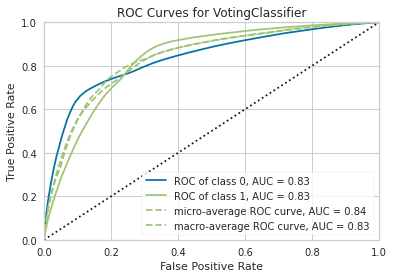

In [42]:
# model plotting
# Area under the ROC curve
plot_model(final_model, plot = 'auc')

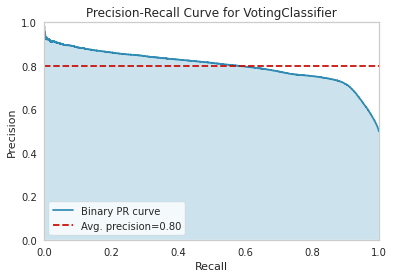

In [43]:
# precision-recall plot
plot_model(final_model, plot = 'pr')

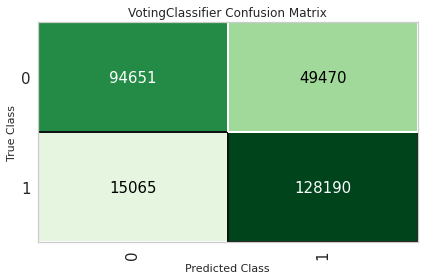

In [44]:
# confusion matrix
plot_model(final_model, plot = 'confusion_matrix')

In [45]:
# save model and parameters
save_model(final_model, 'Final model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[], target='claim',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_strat...
                                                              missing=nan,
                                                              monotone_constraints='()',
                                                              n_estimators=100,
                              

# Submission

In [46]:
# check size of prediction vector
assert(len(idx)==len(unseen_predictions_best))

# create DataFrame with index of test dataset and predictions from the model
sub = pd.DataFrame(list(zip(idx, unseen_predictions_best.Score_1)),columns = ['id', 'claim'])

# DataFrame to csv to be submitted
sub.to_csv('submission.csv', index = False)

# print DataFrame contents for final inspection
print(sub)

             id     claim
0        957919  0.592281
1        957920  0.111757
2        957921  0.628112
3        957922  0.131846
4        957923  0.139548
...         ...       ...
493469  1451388  0.811731
493470  1451389  0.129843
493471  1451390  0.743524
493472  1451391  0.143217
493473  1451392  0.755812

[493474 rows x 2 columns]
